In [ ]:
from google.colab import files
files.upload()

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [11]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1629          6  0.1764706        


In [12]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp

 97% 670M/691M [00:03<00:00, 208MB/s]
100% 691M/691M [00:03<00:00, 197MB/s]


In [13]:
%cd ..

/content


In [14]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from tensorflow.keras.preprocessing import image

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [17]:
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [18]:
breed_all = labels_all['breed']
breed_count = breed_all.value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [19]:
class_name = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(class_name))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [21]:
x_data = np.zeros((len(labels),224,224,3),dtype='float32')
y_data = label_binarize(labels['breed'],classes = class_name)
for i in tqdm(range(len(labels))):
    img = image.load_img("dog_dataset/train/%s.jpg" % labels['id'][i],target_size=(224,224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(),axis=0)
    x_data[i] = x / 255.0

print('\n Train Image shape:', x_data.shape,'size: {:,}'.format(x_data.size))
print('one-hot encoded output shape:',y_data.shape,'size: {:,}'.format(y_data.size))

100%|██████████| 357/357 [00:02<00:00, 173.51it/s]


 Train Image shape: (357, 224, 224, 3) size: 53,738,496
one-hot encoded output shape: (357, 3) size: 1,071


In [22]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size=(5,5), activation='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(7,7), activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size= (5,5), activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer='l2'))
model.add(Dense(64, activation='relu',kernel_regularizer='l2'))
model.add(Dense(len(class_name), activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer= Adam(0.0001),metrics=['accuracy'])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [24]:
x_train_and_val , x_test, y_train_and_val, y_test = train_test_split(x_data, y_data, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train_and_val, y_train_and_val, test_size = 0.2 )

In [25]:
epochs = 100
batch_size = 128

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val))

Epoch 1/100
2/2 [==============================] - 40s 19s/step - loss: 4.9254 - accuracy: 0.3789 - val_loss: 4.9088 - val_accuracy: 0.2769
Epoch 2/100
2/2 [==============================] - 33s 17s/step - loss: 4.8990 - accuracy: 0.3789 - val_loss: 4.8841 - val_accuracy: 0.2769
Epoch 3/100
2/2 [==============================] - 36s 21s/step - loss: 4.8730 - accuracy: 0.3789 - val_loss: 4.8602 - val_accuracy: 0.2769
Epoch 4/100
2/2 [==============================] - 35s 17s/step - loss: 4.8474 - accuracy: 0.3789 - val_loss: 4.8366 - val_accuracy: 0.2769
Epoch 5/100
2/2 [==============================] - 32s 17s/step - loss: 4.8217 - accuracy: 0.3789 - val_loss: 4.8132 - val_accuracy: 0.2769
Epoch 6/100
2/2 [==============================] - 32s 17s/step - loss: 4.7965 - accuracy: 0.3789 - val_loss: 4.7901 - val_accuracy: 0.2769
Epoch 7/100
2/2 [==============================] - 37s 22s/step - loss: 4.7713 - accuracy: 0.3789 - val_loss: 4.7671 - val_accuracy: 0.2769
Epoch 8/100
2/2 [===

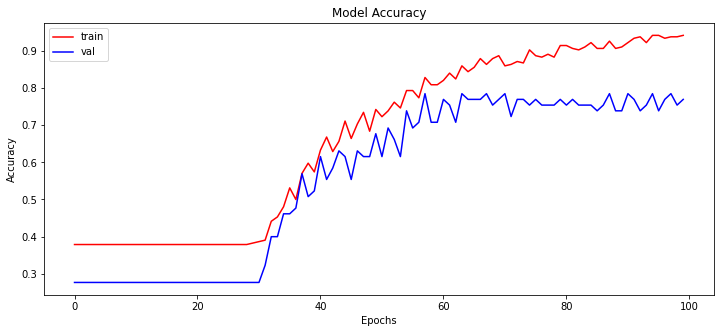

In [27]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color = 'r')
plt.plot(history.history['val_accuracy'],color = 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])

plt.show()

In [ ]:
y_pred = model.predict(x_test)
score = model.evaluate(x_test,y_test)
print("Accuracy over the test set: /n",round((score[1]*100),2),'%')

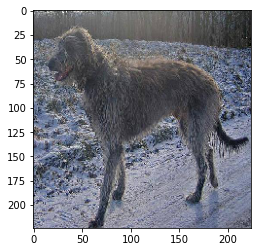

Originally :  scottish_deerhound
Predicted : scottish_deerhound


In [33]:
plt.imshow(x_test[1,:,:,:])
plt.show()

print("Originally : ",labels['breed'][np.argmax(y_test[1])])
print('Predicted :',labels['breed'][np.argmax(y_pred[1])])

In [31]:
model.save('dog_breed.h5')